## Building Environment

In [1]:
# basic tools
import pandas as pd
import numpy as np
import glob
# draw diagram
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# data spliting
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
# modifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
# evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# extend the available check limitations
pd.set_option('max_row', 4000)

## Task 1: Retrieving and Data Preparation

In [2]:
# load all the data from 15 participants in to a list
path = r'C:\Users\User\PDS\Assignment2\Accelerometer'
# rename meaningful title for all the columns
names = ['index','x_acceleration', 'y_acceleration', 'z_acceleration', 'labels' ]
all_files = glob.glob(path + "/*.csv")
li = []
for filename in all_files:
    df= pd.read_csv(filename, sep = ",", header = None, names = names, decimal = '.')
    li.append(df)
# concat list data
accelerometer = pd.concat(li, axis=0, ignore_index =True)



# check whether data type is matched to the original data
accelerometer.dtypes
# check whether there is any null value
accelerometer.isnull().sum()
# sanity check to detect the value of minmum, maximum, mean and so forth value
accelerometer.describe()
# check whether there is any repeated value
accelerometer.duplicated()
# check whether it has extra whitespaces, typos, case sensitive, missing value, data type
# sanity check the label data
print("Before data preparation: ")
print(accelerometer['labels'].value_counts())

# delete the index column because it will not contirbute two every thing, and it will generate misunderstanding during modeling part
accelerometer = accelerometer.drop(columns=["index"])

# create a column name list for eaily operation in the below operations
column_list = accelerometer.columns.values.tolist()
column_list.remove('labels')

# sanity check the other columns 
for i in column_list:
    s=pd.Series(accelerometer[i])
    print("for "+i+", "+ "the value range is between: " + str(s.min())+" ~ "+ str(s.max()))
    
# there are 4000 label is 0 which is a mistake. However, it can be infered by sequential series value
# looking for the neighbor of the missing value from up and down
# if neighbors are conflicted with each other, the down neighbor will be chosen.(only one value in here got a collision)

# mask the target missing values to decearse calculation burden
accelerometer_mask = accelerometer['labels'] == 0

# judge suitable neighbor index for up and down situation (considered out of boundary for index)
def down_is_value(index):
    if index+1 > accelerometer.loc[accelerometer_mask, 'labels'].index.max():
        return -1
    
    index +=1
    while accelerometer.iloc[index, 3] == 0:
        index +=1
    return index
        
def up_is_value(index):
    if index-1 < accelerometer.loc[accelerometer_mask, 'labels'].index.min():
        return -1
    
    index -=1
    while accelerometer.iloc[index, 3] == 0:    
        index -=1
    return index

# 1. if out of boundary, consider another side neighbor
# 2. if collision happened for two neighbor sides, chose the down side neighbor
# 3. the value of neighbors are same, choose upper one to decrease computing burden
for i in accelerometer.loc[accelerometer_mask, 'labels'].index:
    if accelerometer.iloc[down_is_value(i), 3]  != accelerometer.iloc[up_is_value(i), 3]:

        if down_is_value(i) == -1:
            accelerometer.iloc[i, 3] = accelerometer.iloc[up_is_value(i), 3]     
        else:
            accelerometer.iloc[i, 3] = accelerometer.iloc[down_is_value(i), 3]
    else:
        accelerometer.iloc[i, 3] = accelerometer.iloc[up_is_value(i), 3] 
print()
print("Finished data preparation: ")
print(accelerometer['labels'].value_counts())

Before data preparation: 
1    608667
7    593563
4    357064
3    216737
5     51498
2     47878
6     47770
0      3719
Name: labels, dtype: int64
for x_acceleration, the value range is between: 282 ~ 3828
for y_acceleration, the value range is between: 2 ~ 4095
for z_acceleration, the value range is between: 1 ~ 4095

Finished data preparation: 
1    608681
7    593833
4    357244
3    219992
5     51498
2     47878
6     47770
Name: labels, dtype: int64


## Task 2: Data Exploration

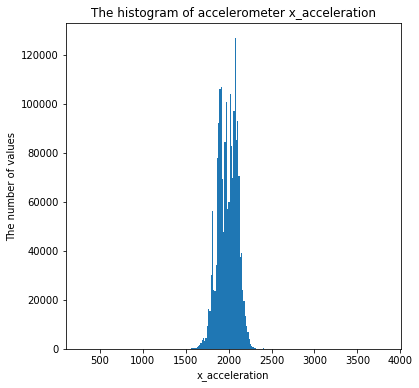

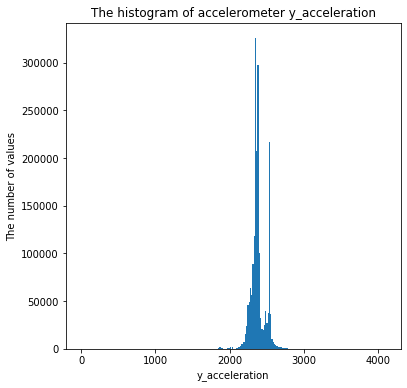

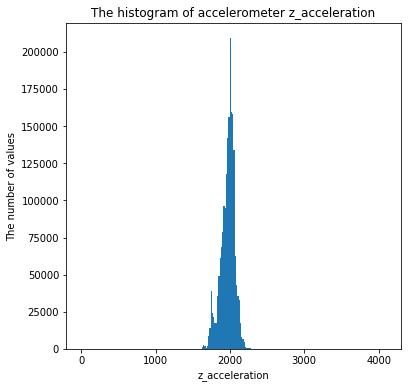

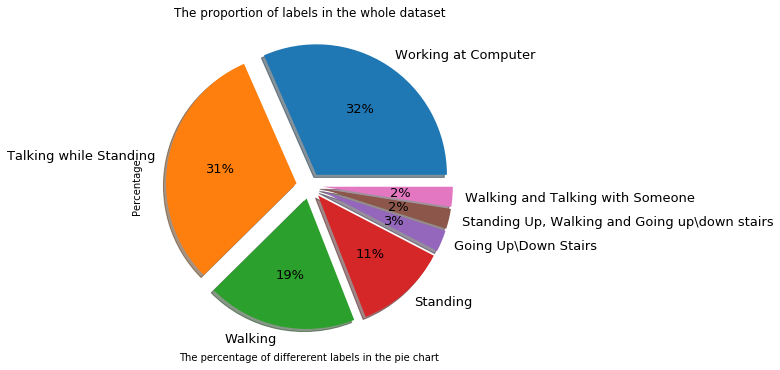

In [26]:
# task 2.1 explore data features for each data features
# explore each columns individually
# for data features x_acceleration, y_acceleration, z_acceleration
for c in column_list:
    # the number of bins is checked by the different interval iteration
    # 240 can show the distribution more clear compared with density diagram
    accelerometer[c].plot(kind='hist', bins =240, figsize=(6,6))
    plt.title('The histogram of accelerometer '+ str(c))
    plt.xlabel('The value of '+ str(c))
    plt.ylabel('The number of values')
    plt.xlabel(str(c))
    plt.show()

# for data feature label
labels = ["Working at Computer", "Talking while Standing", "Walking", "Standing", "Going Up\Down Stairs", "Standing Up, Walking and Going up\down stairs", "Walking and Talking with Someone" ]
accelerometer['labels'].value_counts().plot(kind='pie',figsize = (6,6),labels = labels, autopct = '%.0f%%',textprops = {'fontsize':13, 'color':'k'}, shadow = True, explode = (0.1,0.1,0.1,0.1,0.1,0.1,0.1))
plt.title('The proportion of labels in the whole dataset')
plt.xlabel("The percentage of differerent labels in the pie chart")
plt.ylabel("Percentage")
plt.show()

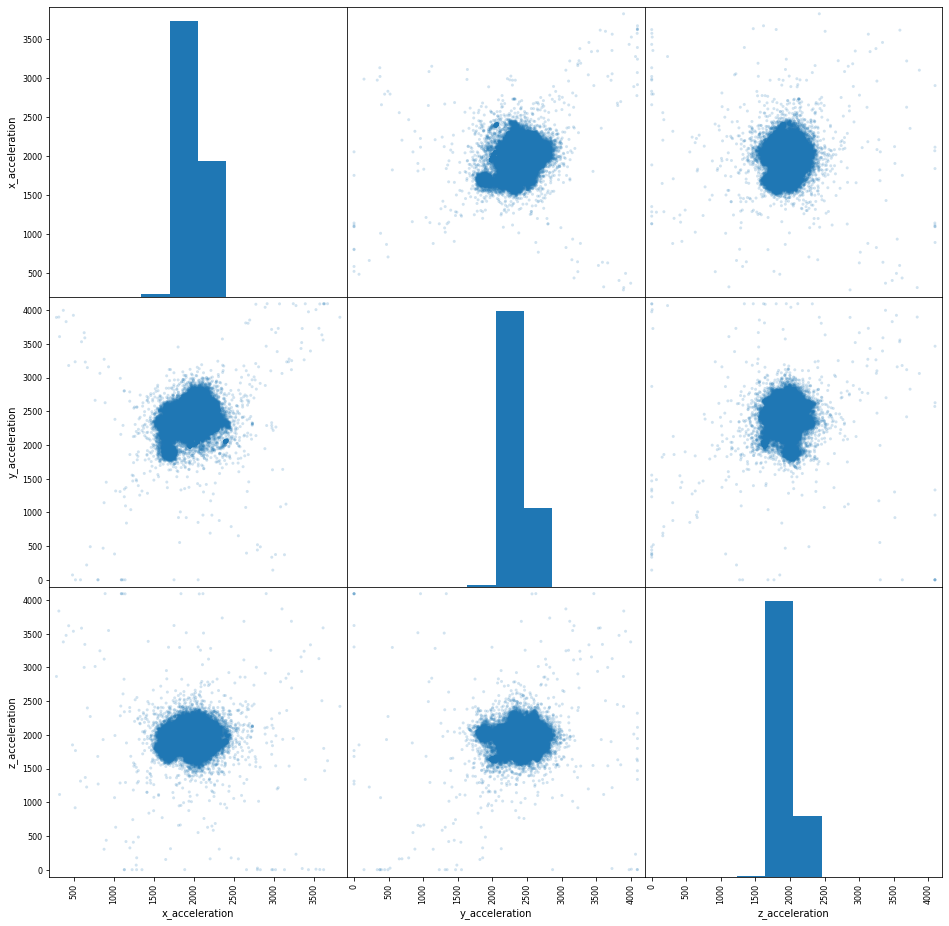

In [11]:
# task 2.2 explore relationship between all pairs of attributes
accelerometer_cp = accelerometer.copy()
accelerometer_cp=accelerometer_cp.drop(columns=["labels"])
# scatter matrix to show the relationship between 'x_acceleration', 'y_acceleration' and 'z_acceleration'
scatter_matrix(accelerometer_cp, alpha=0.2, figsize= (16,16), diagonal= 'hist')
plt.show()

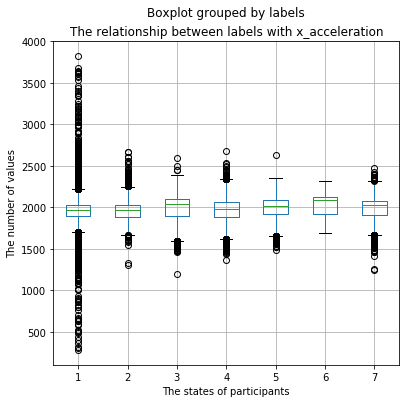

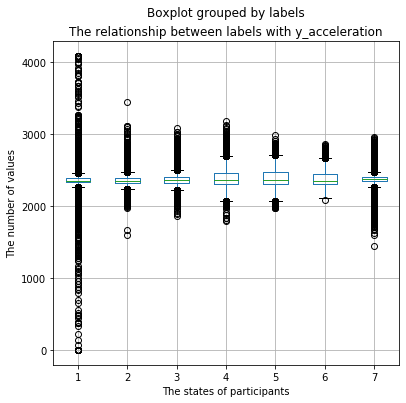

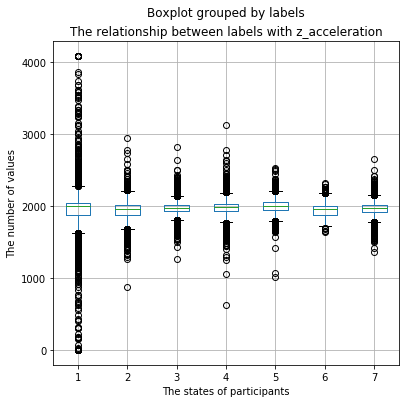

In [21]:
# the relationship between labels and other data features
for c in column_list:
    accelerometer.boxplot(column = c, by ='labels', figsize = (6,6))
    plt.title("The relationship between labels with " + str(c))
    plt.ylabel("The number of values")
    plt.xlabel("The states of participants")
    plt.show()
    

## Task 3: Data Modelling: KNN Classification & Decision Tree

In [3]:
# recorder the target feature
target_feature = accelerometer["labels"]
accelerometer = accelerometer.drop(columns=["labels"])

In [13]:
# task 3.1 Feature selection: Hill climbing based on the performance of KNN
new_Ind = []
cur_MaxScore = 0
col_num = 3
col_Ind_Random = shuffle(range(0, col_num), random_state = 66)

for i in range(0, col_num):
    new_Ind.append(col_Ind_Random[i])
    newData = accelerometer.iloc[:, new_Ind]
 
    X_train, X_test, y_train, y_test = train_test_split(newData, target_feature, test_size = 0.4, random_state = 10)
    clf = KNeighborsClassifier(5, weights = 'distance', n_jobs = -1)
    fit = clf.fit(X_train, y_train)
    newScore = clf.score(X_test, y_test)
    if cur_MaxScore >= newScore:
        new_Ind.remove(col_Ind_Random[i])
    else:
        cur_MaxScore = newScore
        print('Score with ' + str(len(new_Ind)) + ' selceted features: ' + str(cur_MaxScore))
print("Totally, there are " + str(len(new_Ind)) + " features selected: ")
for k in new_Ind:
    print(column_list[k], end = ', ')

[1, 2, 0]
Score with 1 selceted features: 0.38822599578042066
Score with 2 selceted features: 0.5890641919427614
Score with 3 selceted features: 0.7123159458760306
Totally, there are 3 features selected: 
y_acceleration, z_acceleration, x_acceleration, 

In [47]:
# task 3.2 Decision tree with K-Fold cross validation
# environment:
sum_up_score = 0
max_score = 0
number_of_folders = 3

# 'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 8


# parameters ranges for decision tree
criterion_DT = ["gini", "entropy"]
max_depth_DT = range(2, 20)
min_samples_split_DT = range(2,20,1)
min_samples_leaf_DT = range(2,10,5)

# variable to recorder the current best parameters
tuned_criterion = ""
tuned_depth = 0
tuned_min_samples_split = 0
tuned_min_samples_leaf = 0

# classifier for KFold
kf = KFold (n_splits= number_of_folders, random_state=10, shuffle = True)

for a in criterion_DT:
    for b in max_depth_DT:
        for c in min_samples_split_DT:
            for d in min_samples_leaf_DT:
                
                sum_up_score = 0
                tree_model = DecisionTreeClassifier(criterion = a, max_depth = b, min_samples_split = c, min_samples_leaf = d)

                # k-fold cross validation
                for k, (train_index, test_index) in enumerate(kf.split(accelerometer)):
                    X_train, X_test = accelerometer.iloc[train_index], accelerometer.iloc[test_index]
                    y_train, y_test = target_feature.iloc[train_index], target_feature.iloc[test_index] 
                    
                    # train model
                    tree_model.fit(X_train, y_train)
                    
                    # prediction rate for each time
                    cur_score = tree_model.score(X_test, y_test)
                    sum_up_score += cur_score
                    
                 # average score for k fold cross validation 
                average_score = sum_up_score/number_of_folders
                   
                # only recorder the highest one and relevant parameters
                if max_score >= average_score:
                    continue
                else:
                    max_score = average_score
                    
                    # assign variables
                    tuned_criterion = a
                    tuned_depth = b
                    tuned_min_samples_split = c
                    tuned_min_samples_leaf = d
                    
                    print("The highest prediction rate is: " + str(max_score) + '\n'+"parameters: criterion: "+ a + "; max_depth: "+ str(b)
                         + "; min_samples_split: " + str(c) +
                          "; min_samples_leaf: " + str(d))

The highest prediction rate is: 0.4389126343704142
parameters: criterion: gini; max_depth: 2; min_samples_split: 2; min_samples_leaf: 2
The highest prediction rate is: 0.4869442872041782
parameters: criterion: gini; max_depth: 3; min_samples_split: 2; min_samples_leaf: 2
The highest prediction rate is: 0.5223634276138106
parameters: criterion: gini; max_depth: 4; min_samples_split: 2; min_samples_leaf: 2
The highest prediction rate is: 0.5908274239372663
parameters: criterion: gini; max_depth: 5; min_samples_split: 2; min_samples_leaf: 2
The highest prediction rate is: 0.6193977255103388
parameters: criterion: gini; max_depth: 6; min_samples_split: 2; min_samples_leaf: 2
The highest prediction rate is: 0.6193982444802458
parameters: criterion: gini; max_depth: 6; min_samples_split: 2; min_samples_leaf: 7
The highest prediction rate is: 0.6467219817991363
parameters: criterion: gini; max_depth: 7; min_samples_split: 2; min_samples_leaf: 2
The highest prediction rate is: 0.64672613355596

The highest prediction rate is: 0.7380953615727776
parameters: criterion: gini; max_depth: 14; min_samples_split: 17; min_samples_leaf: 7
The highest prediction rate is: 0.7381306515183746
parameters: criterion: gini; max_depth: 14; min_samples_split: 18; min_samples_leaf: 7
The highest prediction rate is: 0.7381514102855674
parameters: criterion: gini; max_depth: 14; min_samples_split: 19; min_samples_leaf: 7
The highest prediction rate is: 0.738859284652131
parameters: criterion: gini; max_depth: 15; min_samples_split: 2; min_samples_leaf: 2
The highest prediction rate is: 0.7396444853223384
parameters: criterion: gini; max_depth: 15; min_samples_split: 2; min_samples_leaf: 7
The highest prediction rate is: 0.7396584974968999
parameters: criterion: gini; max_depth: 15; min_samples_split: 3; min_samples_leaf: 7
The highest prediction rate is: 0.7397192169121891
parameters: criterion: gini; max_depth: 15; min_samples_split: 15; min_samples_leaf: 7
The highest prediction rate is: 0.7397

In [48]:
# used the best parameters for Decsion tree to generate confusion matrix and classification report
# detail results analysis
X_train, X_test, y_train, y_test = train_test_split(accelerometer, target_feature, test_size = 0.4, random_state = 10)
clf = DecisionTreeClassifier(tuned_criterion, max_depth = tuned_depth,
                            min_samples_split = tuned_min_samples_split, 
                             min_samples_leaf = tuned_min_samples_leaf)
fit = clf.fit(X_train, y_train)
y_pre = fit.predict(X_test)
cm = confusion_matrix(y_test, y_pre)
print('Confusion matrix:')
print(cm)
print("=====================================")
print('Classification report:')
print(classification_report(y_test, y_pre))

Confusion matrix:
[[220070   1754   2583   7813    195     80  11432]
 [  7405   3252    948   3987     77     50   3250]
 [  5301    455  39728  19442   1205    944  20538]
 [ 10479    682   8901 103026    845    496  18429]
 [  1831     35   4349   8192   2226    241   3573]
 [   827     59   2261   3789    746   3715   7741]
 [  9509    575   9871  16888    311   2013 198640]]
Classification report:
              precision    recall  f1-score   support

           1       0.86      0.90      0.88    243927
           2       0.48      0.17      0.25     18969
           3       0.58      0.45      0.51     87613
           4       0.63      0.72      0.67    142858
           5       0.40      0.11      0.17     20447
           6       0.49      0.19      0.28     19138
           7       0.75      0.84      0.79    237807

    accuracy                           0.74    770759
   macro avg       0.60      0.48      0.51    770759
weighted avg       0.72      0.74      0.72    77075

In [58]:
# Task 3.3 KNN with K-Fold cross validation with distance
sum_up_score = 0
max_score = 0
number_of_folders = 3

# parameters for KNN
n_neighbors_KNN = range(49,80,2)
weights_KNN = ["distance"]
p_KNN = range(1, 3)

# variable to recorder the current best parameters
tuned_n = 0
tuned_weights = ""
tuned_p = 0

# classifier for KFold
kf = KFold (n_splits= number_of_folders, random_state=10, shuffle = True)

for a in n_neighbors_KNN:
    for b in weights_KNN:
        for c in p_KNN:
            
            sum_up_score = 0
            KNN_model = KNeighborsClassifier(n_neighbors = a, weights = b, p = c, n_jobs = -1)
            
            # 5-fold cross validation
            for k, (train_index, test_index) in enumerate(kf.split(accelerometer)):
                X_train, X_test = accelerometer.iloc[train_index], accelerometer.iloc[test_index]
                y_train, y_test = target_feature.iloc[train_index], target_feature.iloc[test_index] 
                
                # train model
                KNN_model.fit(X_train, y_train)
                # prediction rate for each time
                cur_score = KNN_model.score(X_test, y_test)
                sum_up_score += cur_score
                
            # average score for 5 fold cross validation
            average_score = sum_up_score/number_of_folders
            
            # only recorder the highest one and relevant parameters
            if max_score >= average_score:
                continue
            else:
                max_score = average_score
                tuned_n = a
                tuned_weights = b
                tuned_p = c
                print("The highest prediction rate is: " + str(max_score) + '\n'+"parameters: n_neighbors: "+ str(a) +
                       "; weights: "+ b + "; p: " + str(c))

The highest prediction rate is: 0.7353816707739432
parameters: n_neighbors: 49; weights: distance; p: 1
The highest prediction rate is: 0.7358067066987434
parameters: n_neighbors: 49; weights: distance; p: 2
The highest prediction rate is: 0.7359027159780228
parameters: n_neighbors: 51; weights: distance; p: 2
The highest prediction rate is: 0.7359758906533046
parameters: n_neighbors: 53; weights: distance; p: 2
The highest prediction rate is: 0.7359987253389089
parameters: n_neighbors: 55; weights: distance; p: 2
The highest prediction rate is: 0.7360033960414083
parameters: n_neighbors: 61; weights: distance; p: 2
The highest prediction rate is: 0.7360350532388634
parameters: n_neighbors: 63; weights: distance; p: 2
The highest prediction rate is: 0.7361284676936554
parameters: n_neighbors: 65; weights: distance; p: 2


In [62]:
# Task 3.3 KNN with K-Fold cross validation with uniform
sum_up_score = 0
max_score = 0
number_of_folders = 3

# parameters for KNN
n_neighbors_KNN = range(49,90,2)
weights_KNN = ["uniform"]


# variable to recorder the current best parameters
tuned_n = 0
tuned_weights = ""
tuned_p = 0

# classifier for KFold
kf = KFold (n_splits= number_of_folders, random_state=10, shuffle = True)

for a in n_neighbors_KNN:
    for b in weights_KNN:
        for c in p_KNN:
            
            sum_up_score = 0
            KNN_model = KNeighborsClassifier(n_neighbors = a, weights = b, n_jobs = -1)
            
            # 5-fold cross validation
            for k, (train_index, test_index) in enumerate(kf.split(accelerometer)):
                X_train, X_test = accelerometer.iloc[train_index], accelerometer.iloc[test_index]
                y_train, y_test = target_feature.iloc[train_index], target_feature.iloc[test_index] 
                
                # train model
                KNN_model.fit(X_train, y_train)
                # prediction rate for each time
                cur_score = KNN_model.score(X_test, y_test)
                sum_up_score += cur_score
                
            # average score for 5 fold cross validation
            average_score = sum_up_score/number_of_folders
            
            # only recorder the highest one and relevant parameters
            if max_score >= average_score:
                continue
            else:
                max_score = average_score
                tuned_n = a
                tuned_weights = b
                tuned_p = c
                print("The highest prediction rate is: " + str(max_score) + '\n'+"parameters: n_neighbors: "+ str(a) +
                       "; weights: "+ b)

The highest prediction rate is: 0.7527531324257165
parameters: n_neighbors: 49; weights: uniform
The highest prediction rate is: 0.7527910171958009
parameters: n_neighbors: 51; weights: uniform
The highest prediction rate is: 0.7528776850539215
parameters: n_neighbors: 53; weights: uniform
The highest prediction rate is: 0.7528942920925618
parameters: n_neighbors: 55; weights: uniform
The highest prediction rate is: 0.7529098611558366
parameters: n_neighbors: 57; weights: uniform
The highest prediction rate is: 0.7529581253264851
parameters: n_neighbors: 67; weights: uniform


In [63]:
# used the best parameters for KNN to generate confusion matrix and classification report
# detail results analysis
X_train, X_test, y_train, y_test = train_test_split(accelerometer, target_feature, test_size = 0.4, random_state = 10)
clf = KNeighborsClassifier(n_neighbors = tuned_n, weights = tuned_weights, n_jobs = -1)
fit = clf.fit(X_train, y_train)
y_pre = fit.predict(X_test)
cm = confusion_matrix(y_test, y_pre)
print('Confusion matrix:')
print(cm)
print("=====================================")
print('Classification report:')
print(classification_report(y_test, y_pre))

Confusion matrix:
[[223214   1118   2265   6949     95     84  10202]
 [  7619   3154    910   4128     49     32   3077]
 [  5395    274  40469  19594   1255    751  19875]
 [ 10699    322   6487 106676    292    449  17933]
 [  1825     11   3859   8728   2203    213   3608]
 [   879     31   2236   3706    719   3820   7747]
 [  9742    390   8650  16048    338   1588 201051]]
Classification report:
              precision    recall  f1-score   support

           1       0.86      0.92      0.89    243927
           2       0.60      0.17      0.26     18969
           3       0.62      0.46      0.53     87613
           4       0.64      0.75      0.69    142858
           5       0.44      0.11      0.17     20447
           6       0.55      0.20      0.29     19138
           7       0.76      0.85      0.80    237807

    accuracy                           0.75    770759
   macro avg       0.64      0.49      0.52    770759
weighted avg       0.74      0.75      0.73    77075

## Advanced Topic (Automatic Super Parameters Adjustment)
Grid search cross validation for KNN and Decsion tree + random forest(computing burden)

In [51]:
# task 3.2 Decision tree
# Tuning parameters based on criterion, max_depth, min_samples_split and min_samples_leaf
param_grid = {"criterion":["gini", "entropy"], "max_depth" : range(25, 50, 4), 
              "min_samples_split" : range(70,150,2), "min_samples_leaf" : range(30,60,3)}
grid_search_DT = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs = -1)
X_train, X_test, y_train, y_test = train_test_split(accelerometer, target_feature, random_state = 4)
grid_search_DT.fit(X_train, y_train)
print("Test set score: {:.2f}".format(grid_search_DT.score(X_test, y_test)))
print("Best score on train set: {:.2f}".format(grid_search_DT.best_score_))
print("Best parameters: {}".format(grid_search_DT.best_params_))
print("Run out time: {}".format(grid_search_DT.refit_time_))

Test set score: 0.75
Best score on train set: 0.75
Best parameters: {'criterion': 'entropy', 'max_depth': 25, 'min_samples_leaf': 45, 'min_samples_split': 80}
Run out time: 5.388083457946777


In [52]:
# used the best parameters for decision tree to generate confusion matix and classification report
X_train, X_test, y_train, y_test = train_test_split(accelerometer, target_feature, test_size = 0.4, random_state = 10)
clf = DecisionTreeClassifier(grid_search_DT.best_params_['criterion'], max_depth = grid_search_DT.best_params_['max_depth'],
                            min_samples_split = grid_search_DT.best_params_['min_samples_split'], 
                             min_samples_leaf = grid_search_DT.best_params_['min_samples_leaf'])
fit = clf.fit(X_train, y_train)
y_pre = fit.predict(X_test)
cm = confusion_matrix(y_test, y_pre)

print(cm)
print(classification_report(y_test, y_pre))

[[220423   1356   2520   8501    149     99  10879]
 [  7469   2998    946   4320     67     49   3120]
 [  5165    278  39545  20120   1372    770  20363]
 [  9879    351   7168 106642    554    441  17823]
 [  1721      7   3897   8604   2334    225   3659]
 [   820     19   2172   3951    700   3677   7799]
 [  9442    387   9003  17928    444   1820 198783]]
              precision    recall  f1-score   support

           1       0.86      0.90      0.88    243927
           2       0.56      0.16      0.25     18969
           3       0.61      0.45      0.52     87613
           4       0.63      0.75      0.68    142858
           5       0.42      0.11      0.18     20447
           6       0.52      0.19      0.28     19138
           7       0.76      0.84      0.79    237807

    accuracy                           0.75    770759
   macro avg       0.62      0.49      0.51    770759
weighted avg       0.73      0.75      0.73    770759



In [53]:
# Task 3.3 KNN
# Tuning parameters based on the number of neighbors, weights and the value of p
param_grid = {"n_neighbors":range(1,100,2), "weights":["distance"], "p" : range(1, 3)}
grid_search_KNN = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, n_jobs = -1)
X_train, X_test, y_train, y_test = train_test_split(accelerometer, target_feature, random_state = 4)
grid_search_KNN.fit(X_train, y_train)
print("Test set score{:.2f}".format(grid_search_KNN.score(X_test, y_test)))
print("Best parameters:{}".format(grid_search_KNN.best_params_))
print("Best score on train set:{:.2f}".format(grid_search_KNN.best_score_))
print("Run out time: {}".format(grid_search_KNN.refit_time_))

Test set score0.73
Best parameters:{'n_neighbors': 87, 'p': 2, 'weights': 'distance'}
Best score on train set:0.74
Run out time: 3.2057301998138428


In [54]:
# used the best parameters for KNN to generate confusion matrix and classification report
# detail results analysis
X_train, X_test, y_train, y_test = train_test_split(accelerometer, target_feature, test_size = 0.4, random_state = 10)
clf = KNeighborsClassifier(grid_search_KNN.best_params_['n_neighbors'], p=grid_search_KNN.best_params_['p'], weights = grid_search_KNN.best_params_['weights'])
fit = clf.fit(X_train, y_train)
y_pre = fit.predict(X_test)
cm = confusion_matrix(y_test, y_pre)
print('Confusion matrix:')
print(cm)
print('Classification report:')
print(classification_report(y_test, y_pre))

Confusion matrix:
[[220357   2074   2846   7669    302    210  10469]
 [  7504   3260    940   4140     54     35   3036]
 [  5749    457  38368  20067   1911   1212  19849]
 [ 10543    381   6801 106114    391    525  18103]
 [  1812     19   3685   8723   2209    413   3586]
 [   908     44   2363   3730    623   4003   7467]
 [ 11635    826  11084  16808    939   2769 193746]]
Classification report:
              precision    recall  f1-score   support

           1       0.85      0.90      0.88    243927
           2       0.46      0.17      0.25     18969
           3       0.58      0.44      0.50     87613
           4       0.63      0.74      0.68    142858
           5       0.34      0.11      0.16     20447
           6       0.44      0.21      0.28     19138
           7       0.76      0.81      0.78    237807

    accuracy                           0.74    770759
   macro avg       0.58      0.48      0.51    770759
weighted avg       0.72      0.74      0.72    77075

In [55]:
# knn for uniform
param_grid = {"n_neighbors":range(1,100,2), "weights":["uniform"]}
grid_search_KNN = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, n_jobs = -1)
X_train, X_test, y_train, y_test = train_test_split(accelerometer, target_feature, random_state = 4)
grid_search_KNN.fit(X_train, y_train)
print("Test set score{:.2f}".format(grid_search_KNN.score(X_test, y_test)))
print("Best parameters:{}".format(grid_search_KNN.best_params_))
print("Best score on train set:{:.2f}".format(grid_search_KNN.best_score_))
print("Run out time: {}".format(grid_search_KNN.refit_time_))

Test set score0.75
Best parameters:{'n_neighbors': 53, 'weights': 'uniform'}
Best score on train set:0.75
Run out time: 3.1042001247406006


In [57]:
# used the best parameters for KNN to generate confusion matrix and classification report
# detail results analysis
X_train, X_test, y_train, y_test = train_test_split(accelerometer, target_feature, test_size = 0.4, random_state = 10)
clf = KNeighborsClassifier(grid_search_KNN.best_params_['n_neighbors'], weights = grid_search_KNN.best_params_['weights'])
fit = clf.fit(X_train, y_train)
y_pre = fit.predict(X_test)
cm = confusion_matrix(y_test, y_pre)
print('Confusion matrix:')
print(cm)
print('Classification report:')
print(classification_report(y_test, y_pre))

Confusion matrix:
[[223096   1140   2294   7060    104     81  10152]
 [  7599   3194    907   4128     53     30   3058]
 [  5346    286  40542  19669   1319    782  19669]
 [ 10500    328   6581 106838    338    445  17828]
 [  1796      9   3888   8697   2274    206   3577]
 [   857     29   2235   3742    716   3870   7689]
 [  9667    379   8746  16316    374   1656 200669]]
Classification report:
              precision    recall  f1-score   support

           1       0.86      0.91      0.89    243927
           2       0.60      0.17      0.26     18969
           3       0.62      0.46      0.53     87613
           4       0.64      0.75      0.69    142858
           5       0.44      0.11      0.18     20447
           6       0.55      0.20      0.30     19138
           7       0.76      0.84      0.80    237807

    accuracy                           0.75    770759
   macro avg       0.64      0.49      0.52    770759
weighted avg       0.74      0.75      0.74    77075

In [34]:
# tune parameters for random forest algorithm
# however, it cost a lot time to tune parameters; here, only tune the number of estimators
param_grid = {"n_estimators" : range(50, 300, 10)}
grid_search_RF = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, n_jobs = -1)
X_train, X_test, y_train, y_test = train_test_split(accelerometer, target_feature, random_state = 4)
grid_search_RF.fit(X_train, y_train)
print("Test set score: {:.2f}".format(grid_search_RF.score(X_test, y_test)))
print("Best score on train set: {:.2f}".format(grid_search_RF.best_score_))
print("Best parameters: {}".format(grid_search_RF.best_params_))
print("Run out time: {}".format(grid_search_RF.refit_time_))

Test set score: 0.72
Best score on train set: 0.72
Best parameters: {'n_estimators': 80}
Run out time: 169.9291410446167
